In [1]:
#Load Libraries
import pandas as pd
import sqlite3 as sqlite3
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer # MICE Imputation
import pickle
from xgboost import XGBClassifier
import xgboost as xgb

## Test using SMOTE dataset (20 Apr 2023)

In [2]:
# Refer to previous code for SMOTE implementation
# SMOTE is only applied to train and then saved as csv to avoid recomputing
train_impute_df = pd.read_csv("data/SMOTE_training_data.csv")
test_impute_df = pd.read_csv("data/testing_data_v2.csv")

In [3]:
train_impute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4241600 entries, 0 to 4241599
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   NWCG_REPORTING_AGENCY  object 
 1   CONT_DUR               float64
 2   LONGITUDE              float64
 3   LATITUDE               float64
 4   OWNER_CODE             float64
 5   SOURCE_SYSTEM_TYPE     object 
 6   DISCOVERY_DATE         float64
 7   DISCOVERY_DOY          int64  
 8   FIRE_SIZE              float64
 9   STAT_CAUSE_DESCR       object 
dtypes: float64(6), int64(1), object(3)
memory usage: 323.6+ MB


In [4]:
test_impute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138576 entries, 0 to 138575
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   NWCG_REPORTING_AGENCY  138576 non-null  object 
 1   CONT_DUR               138576 non-null  float64
 2   LONGITUDE              138576 non-null  float64
 3   LATITUDE               138576 non-null  float64
 4   OWNER_CODE             138576 non-null  float64
 5   SOURCE_SYSTEM_TYPE     138576 non-null  object 
 6   DISCOVERY_DATE         138576 non-null  float64
 7   DISCOVERY_DOY          138576 non-null  int64  
 8   FIRE_SIZE              138576 non-null  float64
 9   STAT_CAUSE_DESCR       138576 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 10.6+ MB


<AxesSubplot:>

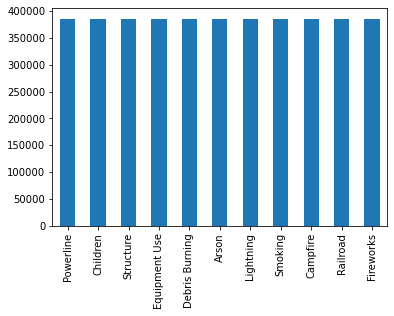

In [5]:
train_impute_df['STAT_CAUSE_DESCR'].value_counts().plot.bar()

### Random Under/Over Sampling to balance dataset
Dataset is made smaller for hyperparameter search due to computational and time restrictions

In [6]:
# set up train and test spilt between x and y
xTrain = train_impute_df.drop(["STAT_CAUSE_DESCR"], axis = 1)
xTest = test_impute_df.drop(["STAT_CAUSE_DESCR"], axis = 1)
yTrain = train_impute_df["STAT_CAUSE_DESCR"]
yTest = test_impute_df["STAT_CAUSE_DESCR"]

In [7]:
#Global variable necessary for function
counts = yTrain.value_counts()

#Change count accordingly for your model
def count_over(colname, count=110000):
    if counts[colname] > count:
        return count
    return counts[colname]

#Perform undersampling
UnderSampleRatio = {
    'Lightning' : count_over('Lightning'), 'Debris Burning' : count_over('Debris Burning'), 'Campfire' : count_over('Campfire'), 
    'Equipment Use' : count_over('Equipment Use'),    
    'Arson' : count_over('Arson'), 'Children' : count_over('Children'), 'Railroad' : count_over('Railroad'),
    'Smoking' : count_over('Smoking'), 'Powerline' : count_over('Powerline'),
    'Fireworks' : count_over('Fireworks'), 'Structure' : count_over('Structure')
}

newSampStrat=RandomUnderSampler(sampling_strategy=UnderSampleRatio,random_state=441) #Goal balance all classes
xTrain,yTrain=newSampStrat.fit_resample(xTrain,yTrain) #perform the balancing newX and newY are balanced X and y

In [8]:
counts = yTrain.value_counts()
counts

Equipment Use     110000
Debris Burning    110000
Powerline         110000
Arson             110000
Fireworks         110000
Children          110000
Lightning         110000
Smoking           110000
Campfire          110000
Structure         110000
Railroad          110000
Name: STAT_CAUSE_DESCR, dtype: int64

<AxesSubplot:>

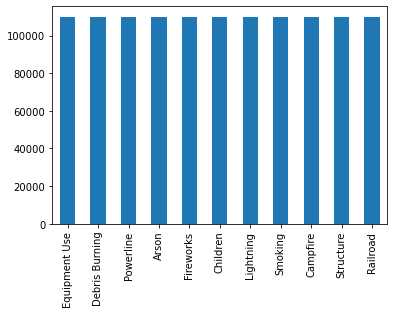

In [9]:
from imblearn.under_sampling import RandomUnderSampler


newSampStrat=RandomUnderSampler(sampling_strategy='not minority',random_state=441) #Goal balance all classes
xTrain,yTrain=newSampStrat.fit_resample(xTrain,yTrain) #perform the balancing newX and newY are balanced X and y
yTrain.value_counts().plot.bar() 

In [10]:
yTrain.value_counts()

Equipment Use     110000
Debris Burning    110000
Powerline         110000
Arson             110000
Fireworks         110000
Children          110000
Lightning         110000
Smoking           110000
Campfire          110000
Structure         110000
Railroad          110000
Name: STAT_CAUSE_DESCR, dtype: int64

### Feature Engineering

In [11]:
train_impute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4241600 entries, 0 to 4241599
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   NWCG_REPORTING_AGENCY  object 
 1   CONT_DUR               float64
 2   LONGITUDE              float64
 3   LATITUDE               float64
 4   OWNER_CODE             float64
 5   SOURCE_SYSTEM_TYPE     object 
 6   DISCOVERY_DATE         float64
 7   DISCOVERY_DOY          int64  
 8   FIRE_SIZE              float64
 9   STAT_CAUSE_DESCR       object 
dtypes: float64(6), int64(1), object(3)
memory usage: 323.6+ MB


In [12]:
#list for cols to scale
cols_to_scale = ['CONT_DUR','LONGITUDE', 'LATITUDE', 'DISCOVERY_DATE', 'DISCOVERY_DOY', "FIRE_SIZE"]

#create and fit scaler
scaler = StandardScaler()
scaler.fit(xTrain[cols_to_scale])

#scale selected data
xTrain[cols_to_scale] = scaler.transform(xTrain[cols_to_scale])
xTest[cols_to_scale] = scaler.transform(xTest[cols_to_scale])

In [13]:
xTrain

,NWCG_REPORTING_AGENCY,CONT_DUR,LONGITUDE,LATITUDE,OWNER_CODE,SOURCE_SYSTEM_TYPE,DISCOVERY_DATE,DISCOVERY_DOY,FIRE_SIZE
0,BIA,-0.089263,-0.197532,1.673047,2.0,FED,0.730599,-0.518719,-0.031374
1,ST/C&L,-0.070063,0.761916,-0.682502,14.0,NONFED,-0.001227,-0.565107,-0.031266
2,ST/C&L,0.133095,0.080135,0.316468,14.0,NONFED,0.881776,-0.367959,0.014048
3,ST/C&L,-0.089263,0.453091,-1.167113,14.0,NONFED,-1.084378,1.893442,-0.030875
4,ST/C&L,-0.089263,0.877260,-0.387324,8.0,NONFED,1.134541,-1.504458,-0.031303
...,...,...,...,...,...,...,...,...,...
1209995,ST/C&L,-0.069981,0.267840,0.578480,8.0,FED,-1.755056,-0.634688,-0.031131
1209996,BIA,-0.089263,-0.413671,0.292435,2.0,FED,-1.157244,-0.228796,-0.031374
1209997,ST/C&L,-0.089263,0.725839,-0.958278,14.0,NONFED,0.963088,1.986217,-0.031245
1209998,ST/C&L,0.041212,0.584678,0.731509,8.0,NONFED,-0.710725,0.014739,-0.031317


In [14]:
# OHE for categorical variables
xTrain_model = pd.get_dummies(xTrain, columns = ["NWCG_REPORTING_AGENCY", "OWNER_CODE", "SOURCE_SYSTEM_TYPE"])
xTrain_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210000 entries, 0 to 1209999
Data columns (total 34 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   CONT_DUR                      1210000 non-null  float64
 1   LONGITUDE                     1210000 non-null  float64
 2   LATITUDE                      1210000 non-null  float64
 3   DISCOVERY_DATE                1210000 non-null  float64
 4   DISCOVERY_DOY                 1210000 non-null  float64
 5   FIRE_SIZE                     1210000 non-null  float64
 6   NWCG_REPORTING_AGENCY_BIA     1210000 non-null  uint8  
 7   NWCG_REPORTING_AGENCY_BLM     1210000 non-null  uint8  
 8   NWCG_REPORTING_AGENCY_BOR     1210000 non-null  uint8  
 9   NWCG_REPORTING_AGENCY_FS      1210000 non-null  uint8  
 10  NWCG_REPORTING_AGENCY_FWS     1210000 non-null  uint8  
 11  NWCG_REPORTING_AGENCY_IA      1210000 non-null  uint8  
 12  NWCG_REPORTING_AGENCY_NPS   

In [15]:
xTest_model = pd.get_dummies(xTest, columns = ["NWCG_REPORTING_AGENCY", "OWNER_CODE", "SOURCE_SYSTEM_TYPE"])
xTest_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138576 entries, 0 to 138575
Data columns (total 33 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   CONT_DUR                      138576 non-null  float64
 1   LONGITUDE                     138576 non-null  float64
 2   LATITUDE                      138576 non-null  float64
 3   DISCOVERY_DATE                138576 non-null  float64
 4   DISCOVERY_DOY                 138576 non-null  float64
 5   FIRE_SIZE                     138576 non-null  float64
 6   NWCG_REPORTING_AGENCY_BIA     138576 non-null  uint8  
 7   NWCG_REPORTING_AGENCY_BLM     138576 non-null  uint8  
 8   NWCG_REPORTING_AGENCY_DOD     138576 non-null  uint8  
 9   NWCG_REPORTING_AGENCY_FS      138576 non-null  uint8  
 10  NWCG_REPORTING_AGENCY_FWS     138576 non-null  uint8  
 11  NWCG_REPORTING_AGENCY_IA      138576 non-null  uint8  
 12  NWCG_REPORTING_AGENCY_NPS     138576 non-nul

In [16]:
# keeping only same columns as xTrain
cols_to_keep = [col for col in xTest_model.columns if col in xTrain_model.columns]
xTest_model = xTest_model[cols_to_keep]
xTest_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138576 entries, 0 to 138575
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   CONT_DUR                      138576 non-null  float64
 1   LONGITUDE                     138576 non-null  float64
 2   LATITUDE                      138576 non-null  float64
 3   DISCOVERY_DATE                138576 non-null  float64
 4   DISCOVERY_DOY                 138576 non-null  float64
 5   FIRE_SIZE                     138576 non-null  float64
 6   NWCG_REPORTING_AGENCY_BIA     138576 non-null  uint8  
 7   NWCG_REPORTING_AGENCY_BLM     138576 non-null  uint8  
 8   NWCG_REPORTING_AGENCY_FS      138576 non-null  uint8  
 9   NWCG_REPORTING_AGENCY_FWS     138576 non-null  uint8  
 10  NWCG_REPORTING_AGENCY_IA      138576 non-null  uint8  
 11  NWCG_REPORTING_AGENCY_NPS     138576 non-null  uint8  
 12  NWCG_REPORTING_AGENCY_ST/C&L  138576 non-nul

In [17]:
xTrain_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210000 entries, 0 to 1209999
Data columns (total 34 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   CONT_DUR                      1210000 non-null  float64
 1   LONGITUDE                     1210000 non-null  float64
 2   LATITUDE                      1210000 non-null  float64
 3   DISCOVERY_DATE                1210000 non-null  float64
 4   DISCOVERY_DOY                 1210000 non-null  float64
 5   FIRE_SIZE                     1210000 non-null  float64
 6   NWCG_REPORTING_AGENCY_BIA     1210000 non-null  uint8  
 7   NWCG_REPORTING_AGENCY_BLM     1210000 non-null  uint8  
 8   NWCG_REPORTING_AGENCY_BOR     1210000 non-null  uint8  
 9   NWCG_REPORTING_AGENCY_FS      1210000 non-null  uint8  
 10  NWCG_REPORTING_AGENCY_FWS     1210000 non-null  uint8  
 11  NWCG_REPORTING_AGENCY_IA      1210000 non-null  uint8  
 12  NWCG_REPORTING_AGENCY_NPS   

In [18]:
# Encode classes
lc = LabelEncoder() 

lc_yTrain = lc.fit_transform(yTrain) 
lc_yTrain

lc_yTest = lc.transform(yTest) 
lc_yTest = pd.Series(lc_yTest)
lc_yTest


0         6
1         4
2         1
3         0
4         6
         ..
138571    6
138572    0
138573    3
138574    3
138575    3
Length: 138576, dtype: int32

### Model Training

### Hyperparameter tuning using grid search on subset of data

In [19]:
params = {
        #'gamma': [0.3, 1],
        'max_depth': [40, 100],
       'learning_rate' : [0.01, 0.1, 0.9],
        'random_state' : [441],
        'reg_alpha' : [0.5, 0.8]
        }


In [20]:
xTrain_model

,CONT_DUR,LONGITUDE,LATITUDE,DISCOVERY_DATE,DISCOVERY_DOY,FIRE_SIZE,NWCG_REPORTING_AGENCY_BIA,NWCG_REPORTING_AGENCY_BLM,NWCG_REPORTING_AGENCY_FS,NWCG_REPORTING_AGENCY_FWS,...,OWNER_CODE_9.0,OWNER_CODE_10.0,OWNER_CODE_11.0,OWNER_CODE_12.0,OWNER_CODE_13.0,OWNER_CODE_14.0,OWNER_CODE_15.0,SOURCE_SYSTEM_TYPE_FED,SOURCE_SYSTEM_TYPE_INTERAGCY,SOURCE_SYSTEM_TYPE_NONFED
0,-0.067644,-0.201154,1.680507,0.735248,-0.519947,-0.030292,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,-0.053280,0.760631,-0.679881,0.004034,-0.566323,-0.030186,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0.098709,0.077188,0.321141,0.886298,-0.369227,0.014235,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,-0.067644,0.451054,-1.165487,-1.078212,1.891586,-0.029803,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,-0.067644,0.876256,-0.384096,1.138852,-1.505430,-0.030222,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,-0.011692,0.952399,-0.113999,0.521752,1.752459,-0.030031,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
109996,-0.067644,0.760270,-0.417497,1.075250,0.882916,-0.030267,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
109997,-0.007484,0.946544,-0.304666,0.998022,-1.354709,-0.029414,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
109998,-0.067644,0.332071,1.253566,1.018788,-0.751826,-0.030338,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
%%time

#Count was 3500 per class when tuning

estimator = XGBClassifier(objective = "multi:softprob", n_estimators=200) 

# crossvalidation folds
cv = KFold(
    n_splits=5,  # number of folds
    shuffle=True # protects against data being ordered, e.g., all successes first
)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring = 'accuracy',
    #n_jobs = ,
    cv = cv,
    verbose=3,
    refit = True
)

grid_search.fit(xTrain_model, lc_yTrain)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END learning_rate=0.01, max_depth=40, random_state=441, reg_alpha=0.5;, score=0.556 total time=11.0min
[CV 2/5] END learning_rate=0.01, max_depth=40, random_state=441, reg_alpha=0.5;, score=0.540 total time=11.0min
[CV 3/5] END learning_rate=0.01, max_depth=40, random_state=441, reg_alpha=0.5;, score=0.548 total time=11.2min
[CV 4/5] END learning_rate=0.01, max_depth=40, random_state=441, reg_alpha=0.5;, score=0.553 total time=11.0min
[CV 5/5] END learning_rate=0.01, max_depth=40, random_state=441, reg_alpha=0.5;, score=0.549 total time=11.1min
[CV 1/5] END learning_rate=0.01, max_depth=40, random_state=441, reg_alpha=0.8;, score=0.554 total time=10.8min
[CV 2/5] END learning_rate=0.01, max_depth=40, random_state=441, reg_alpha=0.8;, score=0.542 total time=10.8min
[CV 3/5] END learning_rate=0.01, max_depth=40, random_state=441, reg_alpha=0.8;, score=0.550 total time=10.9min
[CV 4/5] END learning_rate=0.01, max_depth=

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     i...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.9],
                         'max_depth': [40, 100], 'random_state': [441],
                         'reg_alpha': [0.5, 0.8]},
             scoring='accuracy', verbose=3)

In [23]:
grid_search.cv_results_

{'mean_fit_time': array([660.71047578, 647.83768134, 673.60431728, 662.93366508,
        664.14345131, 653.64221649, 681.55183554, 670.92230568,
        393.19705267, 395.93431792, 394.58572593, 398.94935966]),
 'std_fit_time': array([ 4.60734579,  2.80058259,  4.28577621, 11.02567465,  3.27537672,
         3.8089809 ,  4.09583836,  3.57932502,  1.26982501,  2.62269819,
         1.97136775,  3.98864104]),
 'mean_score_time': array([2.56127796, 2.50306387, 2.67240801, 2.48750105, 1.64974203,
        1.6001071 , 1.67490001, 1.66050725, 0.80384016, 0.85491252,
        0.8108305 , 0.81462007]),
 'std_score_time': array([0.07215945, 0.12195588, 0.09243618, 0.08985217, 0.0744826 ,
        0.06988363, 0.08894502, 0.07747964, 0.01420812, 0.04314875,
        0.02085351, 0.02073251]),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.9, 0.9,
                    0.9, 0.9],
              mask=[False, False, False, False, False, False, False, False,
          

In [24]:
print("The best training accuracy score is ", grid_search.best_score_ * 100, "%")

The best training accuracy score is  57.58090909090908 %


In [25]:
print("The best parameter combination is:\n ", grid_search.best_params_)

The best parameter combination is:
  {'learning_rate': 0.1, 'max_depth': 40, 'random_state': 441, 'reg_alpha': 0.8}


In [26]:
final_tuning_model = grid_search.best_estimator_

In [27]:
pickle.dump(grid_search, open('grid_search_XGB', 'wb'))

### Final training model
Use the best hyperparameters from above to train on 30% of training data (~1million rows) due to computational constraints

In [19]:
test_impute_df.columns

Index(['NWCG_REPORTING_AGENCY', 'CONT_DUR', 'LONGITUDE', 'LATITUDE',
       'OWNER_CODE', 'SOURCE_SYSTEM_TYPE', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'FIRE_SIZE', 'STAT_CAUSE_DESCR'],
      dtype='object')

In [20]:
grid_search=pickle.load(open('grid_search_XGB', 'rb'))
print("The best parameter combination is:\n ", grid_search.best_params_)

The best parameter combination is:
  {'learning_rate': 0.1, 'max_depth': 40, 'random_state': 441, 'reg_alpha': 0.8}


In [21]:
%%time
final_estimator = XGBClassifier(objective = "multi:softprob", max_depth = 40, n_estimators = 200,
                          random_state = 441, reg_alpha = 0.8) 

final_estimator.fit(xTrain_model, lc_yTrain)

Wall time: 4h 19min 2s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [22]:
%%time
pickle.dump(final_estimator, open('final_estimator_XGB', 'wb'))

Wall time: 16.9 s


### Prediction accuracy on final test set

In [23]:
final_estimator_XGB=pickle.load(open('final_estimator_XGB', 'rb'))
cols_order = final_estimator_XGB.get_booster().feature_names
cols_order

['CONT_DUR',
 'LONGITUDE',
 'LATITUDE',
 'DISCOVERY_DATE',
 'DISCOVERY_DOY',
 'FIRE_SIZE',
 'NWCG_REPORTING_AGENCY_BIA',
 'NWCG_REPORTING_AGENCY_BLM',
 'NWCG_REPORTING_AGENCY_BOR',
 'NWCG_REPORTING_AGENCY_FS',
 'NWCG_REPORTING_AGENCY_FWS',
 'NWCG_REPORTING_AGENCY_IA',
 'NWCG_REPORTING_AGENCY_NPS',
 'NWCG_REPORTING_AGENCY_ST/C&L',
 'NWCG_REPORTING_AGENCY_TRIBE',
 'OWNER_CODE_0.0',
 'OWNER_CODE_1.0',
 'OWNER_CODE_2.0',
 'OWNER_CODE_3.0',
 'OWNER_CODE_4.0',
 'OWNER_CODE_5.0',
 'OWNER_CODE_6.0',
 'OWNER_CODE_7.0',
 'OWNER_CODE_8.0',
 'OWNER_CODE_9.0',
 'OWNER_CODE_10.0',
 'OWNER_CODE_11.0',
 'OWNER_CODE_12.0',
 'OWNER_CODE_13.0',
 'OWNER_CODE_14.0',
 'OWNER_CODE_15.0',
 'SOURCE_SYSTEM_TYPE_FED',
 'SOURCE_SYSTEM_TYPE_INTERAGCY',
 'SOURCE_SYSTEM_TYPE_NONFED']

In [24]:
#These columns aren't in xTest so we have to add them
xTest_model[['NWCG_REPORTING_AGENCY_BOR', 'OWNER_CODE_0.0']]=0
xTest_model=xTest_model[cols_order]

In [25]:
# Predict accuracy on the final test set
yPred = final_estimator.predict(xTest_model) 

yPred = [round(value) for value in yPred]

accuracy = accuracy_score(lc_yTest, yPred) 

print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Test Accuracy: 57.66%


Text(0.5, 1.0, 'Variable Importance for XGBoost Classifier')

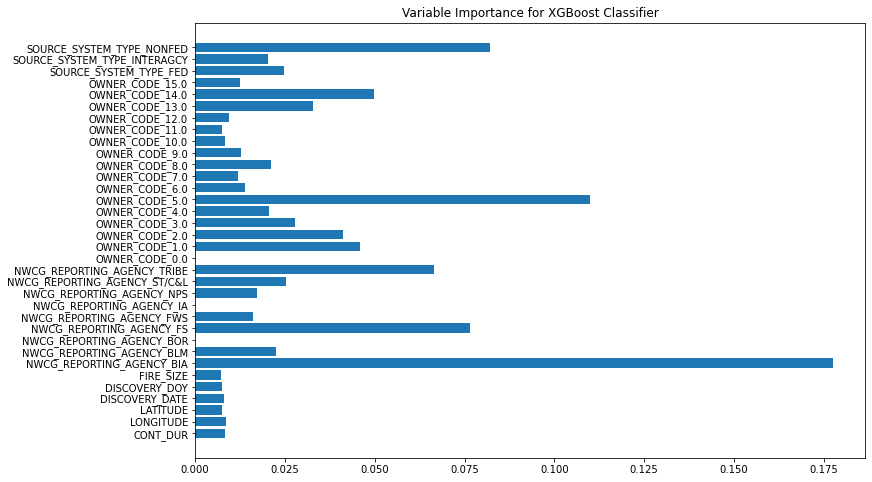

In [31]:
plt.figure(figsize=(12,8))  
plt.barh(cols_order, final_estimator.feature_importances_)
plt.title('Variable Importance for XGBoost Classifier')

In [32]:
lc.classes_

array(['Arson', 'Campfire', 'Children', 'Debris Burning', 'Equipment Use',
       'Fireworks', 'Lightning', 'Powerline', 'Railroad', 'Smoking',
       'Structure'], dtype=object)

In [33]:
from sklearn.metrics import classification_report
print("\nClassification Report\n")
print(classification_report(lc_yTest, yPred, target_names = lc.classes_))


Classification Report

                precision    recall  f1-score   support

         Arson       0.59      0.56      0.57     28181
      Campfire       0.46      0.49      0.47      7639
      Children       0.26      0.25      0.26      6129
Debris Burning       0.62      0.61      0.61     43137
 Equipment Use       0.45      0.40      0.42     14485
     Fireworks       0.38      0.65      0.48      1138
     Lightning       0.84      0.82      0.83     27540
     Powerline       0.16      0.32      0.21      1409
      Railroad       0.43      0.56      0.49      3228
       Smoking       0.19      0.19      0.19      5290
     Structure       0.07      0.18      0.10       400

      accuracy                           0.58    138576
     macro avg       0.40      0.46      0.42    138576
  weighted avg       0.59      0.58      0.58    138576

